In [27]:
#########################################################################
#                                                                       #
# Import Kepler Data and Pick out points corresponding to 124 < t < 125 #
#                                                                       #
#########################################################################

import math
import numpy as np
import kplr
import matplotlib.pyplot as plt
%matplotlib notebook

# Find the target KOI.
client = kplr.API()
koi = client.koi(97.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Open the first dataset and read it
f = lcs[0].open()

hdu_data = f[1].data
time = hdu_data["time"]

index = np.where((time>124)&(time<125))
hdu = hdu_data[index]


flux_eclipse = hdu["sap_flux"]
time_eclipse = hdu["time"]
err_eclipse = hdu["sap_flux_err"]

f.close()

In [28]:
#########################################################################
#                                                                       #
# Perform two sigma exclusion 5 times to remove points 2 sigma away     #
# from the mean and calculate unobscured flux. Should get 33 entries    #
#                                                                       #
#########################################################################

non_transit = flux_eclipse

for i in range(5):
    mean = np.mean(non_transit)
    sigma = np.std(non_transit)

    twosigtest = abs(non_transit - mean)/(sigma)
    new_indices = np.where((twosigtest<2))
    non_transit = non_transit[new_indices]

unobscured_mean = np.mean(non_transit)

raw_Flux_Ratios = np.zeros(len(flux_eclipse))
for i in range(len(flux_eclipse)):
    raw_Flux_Ratios [i] = flux_eclipse[i] / unobscured_mean

print(len(non_transit))

33


In [51]:
########################################################################
#                                                                      #
#      Perform model calculations using scipy integration package      #
#                                                                      #
########################################################################

from scipy.integrate import quad

#set parameters
p = 0.0775
tau_low = 0.08
tau_high = 0.13
tau = 0.08
tau_step = 0.0001
t_0 = 124.51

tau_values = np.zeros(int((tau_high - tau_low) / tau_step))

#convert times in UTC to z (normalized separation of the centers)
#t_0 = time of max flux eclipse
#tau - related to duration of eclipse

#define Delta function, specific intensity, numerator and denominator of flux ratio function
def Delta_Function(r,p,z): 
    r_squared = math.pow(r,2)
    z_squared = math.pow(z,2)
    p_squared = math.pow(p,2)
    if r >= z+p or r <= z-p:
        return 0 
    elif r + z <= p: 
        return 1
    else:
        return (math.pow(math.pi,-1)) * math.acos((z_squared - p_squared + r_squared) / (2*z*r))

def I(r):
    '''A Limb-darkening function'''
    mu = (1 - (r**2))**(0.5)
    return 1 - (1 - (mu**(0.5)))

def func1(r, p, z):
    return I(r) * (1 - Delta_Function(r,p,abs(z))) * 2 * r

def func2(r):
    return I(r) * 2 * r

#find model flux values
Model_Fluxes = np.zeros((int((tau_high - tau_low) / tau_step), len(flux_eclipse)))

for i in range(int((tau_high - tau_low) / tau_step)):
    z_Kepler = np.zeros(len(flux_eclipse))
    tau_values[i] = tau
    for j in range(len(flux_eclipse)):
        z_Kepler[j] = (time_eclipse[j] - t_0) / tau
        z_i = z_Kepler[j]
        Model_Fluxes[i,j] = quad(func1, 0, 1, args = (p, z_i))[0]/(quad(func2, 0, 1)[0])
    tau += tau_step


In [52]:
########################################################################
#                                                                      #
#      Compute chi squared                                             #
#                                                                      #
########################################################################

chi_squared = np.zeros(int((tau_high - tau_low) / tau_step))

for i in range(int((tau_high - tau_low) / tau_step)):
    chi_squared_i = 0
    for j in range(len(flux_eclipse)):
        chi_squared_i += math.pow((raw_Flux_Ratios[j] - Model_Fluxes[i,j])/(err_eclipse[j]/unobscured_mean),2)
    chi_squared[i] = chi_squared_i

<IPython.core.display.Javascript object>


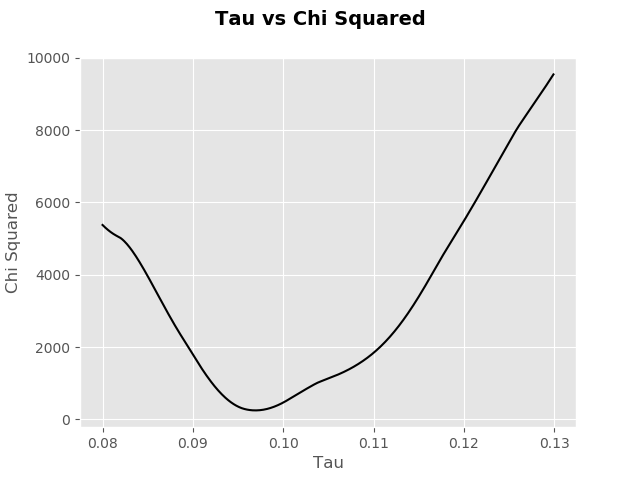

In [53]:
########################################################################
#                                                                      #
#      Plot tau vs chi squared and compute p-values                    #
#                                                                      #
########################################################################

from matplotlib.font_manager import FontProperties

fig = plt.figure()
plt.style.use('ggplot')
ax = fig.add_subplot(111)

plt.plot(tau_values, chi_squared, color = 'k')
    
fig.suptitle('Tau vs Chi Squared', fontsize=14, fontweight='bold')
ax.set_xlabel('Tau')
ax.set_ylabel('Chi Squared')

nu = len(flux_eclipse) - 3
a = nu / 2
x = chi_squared / 2

def Incomplete_Gamma_Integrand(t,a): 
    return(math.exp(-t) * math.pow(t,a-1))

def p_value(a, x):
    return(quad(Incomplete_Gamma_Integrand, x, math.inf, args=(a))[0] / quad(Incomplete_Gamma_Integrand, 0, math.inf, args=(a))[0])

p = np.zeros(len(x))

for i in range(len(p)):
    p[i] = p_value(a,x[i])


In [54]:
########################################################################
#                                                                      #
#     Find and report best fit tau value and estimate uncertainty      #
#                                                                      #
########################################################################

min_chi = np.min(chi_squared)
min_chi_index = np.where(chi_squared == min_chi)
min_tau = tau_values[min_chi_index]

epsilon = .5
min_chi_plus1 = min_chi + 1
min_chi_plus1_index = np.where((chi_squared <= min_chi_plus1 + epsilon)&(chi_squared >= min_chi_plus1 - epsilon))
min_tau_plus1 = tau_values[min_chi_plus1_index]

print("minimum chi value: " + str(min_chi))
print("minimum corresponding tau value: " + str(min_tau))

print("minimum chi plus 1 value: " + str(min_chi_plus1))
print("minimum corresponding tau values: " + str(min_tau_plus1))

print("one sigma uncertainty: " + str(min_tau_plus1[1] - min_tau[0]))

minimum chi value: 247.224231309
minimum corresponding tau value: [ 0.0969]
minimum chi plus 1 value: 248.224231309
minimum corresponding tau values: [ 0.0967  0.0971]
one sigma uncertainty: 0.0002
